In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import *
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

In [93]:
df = pd.read_csv('freq_exposition_achat_merged.csv')

In [94]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13943 entries, 0 to 13942
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   13943 non-null  int64  
 1   customer_id  13943 non-null  object 
 2   sales        13943 non-null  float64
 3   quantity     13943 non-null  float64
 4   freq         13943 non-null  int64  
 5   device_id    13943 non-null  object 
 6   freq_tv      13943 non-null  int64  
 7   dsp_id       13943 non-null  object 
 8   freq_prog    13943 non-null  int64  
 9   freq_totale  13943 non-null  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 1.1+ MB
None


In [95]:
display(df.head(10))

,Unnamed: 0,customer_id,sales,quantity,freq,device_id,freq_tv,dsp_id,freq_prog,freq_totale
0,0,re00CKn2yOaub2t96K,46.67,1.0,1,ctvOeSltoMMJ,2,dspjS8smJIRHKBhwamdxBzZzZh1CJi,1,3
1,1,re00aRkgItYQpIBs4v,78.98,1.0,1,ctv4YVSu6w48,1,dspDxWVaZM9Z4zFgpWlqyCe9YFZ6xk,1,2
2,2,re00fY6oH5hwDeHicN,172.97,3.0,3,ctvWuzHNZ43W,1,dspcvhk8ZfZ6nrN3eQMm2Q6pbbM2Gh,1,2
3,3,re00itkOXBMIgSS7yM,20.49,1.0,1,ctvz0yKxiDe6,1,dspcBhtHgoJg7gJTDZXbz8C8K2ysrS,2,3
4,4,re012Muoq9mKQlWPfh,175.97,2.0,2,ctvM7UVrUMbm,1,dspNAGOKX0IiVJsUSpBSmytdOoCVPV,1,2
5,5,re013Kr8KhunDrCoAe,418.32,9.0,9,ctvvrCfzbf3q,10,dspToKbpzMZQbwp5mEmDXqDl3Gs8Dd,2,12
6,6,re015otsriXJHU4ruM,72.98,2.0,2,ctv06s7A69aP,2,dspTssEGLDh1n9UtIUej1acLydfk1o,3,5
7,7,re01OUEUgnnOBS72bn,209.96,4.0,3,ctvyUo1GfoTI,1,dspI9DT6UQe8WaZNFObEpwFSZuNld4,1,2
8,8,re01WVNrsWl2LsxzO3,79.98,1.0,1,ctvkmdciOjCn,3,dspvlFOdxsy1Z6nyFxkNkvTSn0E7GC,2,5
9,9,re01qhW7SJo6E5Nk3s,115.98,2.0,2,ctvcKwN943eM,8,dspmabJY3iNTZevF2pDB4yzVoJovnE,4,12


## Data Cleaning

In [96]:
print(df.dtypes)
print(df.nunique())

Unnamed: 0       int64
customer_id     object
sales          float64
quantity       float64
freq             int64
device_id       object
freq_tv          int64
dsp_id          object
freq_prog        int64
freq_totale      int64
dtype: object
Unnamed: 0     13943
customer_id    13943
sales           4586
quantity          47
freq              37
device_id      13943
freq_tv           64
dsp_id         13943
freq_prog         64
freq_totale       79
dtype: int64


### Missing Values

In [97]:
def count_missing_values_summary(df):
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / len(df)) * 100
    missing_columns = missing_counts[missing_counts > 0]
    missing_summary = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage (%)': missing_percentage}
    ).sort_values(by='Missing Count', ascending=False)
    
    return missing_summary

# Example usage
summary = count_missing_values_summary(df)
print(summary)

             Missing Count  Missing Percentage (%)
Unnamed: 0               0                     0.0
customer_id              0                     0.0
sales                    0                     0.0
quantity                 0                     0.0
freq                     0                     0.0
device_id                0                     0.0
freq_tv                  0                     0.0
dsp_id                   0                     0.0
freq_prog                0                     0.0
freq_totale              0                     0.0


## Analysis of correlation

### Data Exploration of 'customer_id', 'device_id', 'dsp_id'

In [98]:
# Check if any of the IDs have duplicate entries
duplicate_customer_ids = df['customer_id'].duplicated().sum()
duplicate_device_ids = df['device_id'].duplicated().sum()
duplicate_dsp_ids = df['dsp_id'].duplicated().sum()

print(f"Duplicate customer IDs: {duplicate_customer_ids}")
print(f"Duplicate device IDs: {duplicate_device_ids}")
print(f"Duplicate DSP IDs: {duplicate_dsp_ids}")

Duplicate customer IDs: 0
Duplicate device IDs: 0
Duplicate DSP IDs: 0


In [99]:
# Add a validation column to check if freq_totale equals the sum of freq_tv and freq_prog
# Check for inconsistencies
inconsistent_rows = df[(df['freq_tv'] + df['freq_prog']) != df['freq_totale']]

print(f"Number of inconsistent rows in frequency totals: {len(inconsistent_rows)}")

Number of inconsistent rows in frequency totals: 0


### Creation of Derived Metrics

In [100]:
# Add binary columns for exposure
df['exposed_tv'] = df['freq_tv'] > 0
df['exposed_prog'] = df['freq_prog'] > 0

# Add a combined exposure flag
df['exposed_combined'] = df['exposed_tv'] & df['exposed_prog']

In [101]:
# Compute the proportion of exposure per channel
# Avoid division by zero by replacing zero totals with NaN or handling explicitly
df['tv_ratio'] = df['freq_tv'] / df['freq_totale'].replace(0, float('nan'))
df['prog_ratio'] = df['freq_prog'] / df['freq_totale'].replace(0, float('nan'))

In [102]:
# Add a derived metric for average purchase value
# Avoid division by zero for quantity by handling explicitly
df['avg_sales_per_quantity'] = df['sales'] / df['quantity'].replace(0, float('nan'))

# Optional: Display the updated DataFrame structure
display(df.head())

,Unnamed: 0,customer_id,sales,quantity,freq,device_id,freq_tv,dsp_id,freq_prog,freq_totale,exposed_tv,exposed_prog,exposed_combined,tv_ratio,prog_ratio,avg_sales_per_quantity
0,0,re00CKn2yOaub2t96K,46.67,1.0,1,ctvOeSltoMMJ,2,dspjS8smJIRHKBhwamdxBzZzZh1CJi,1,3,True,True,True,0.666667,0.333333,46.670000
1,1,re00aRkgItYQpIBs4v,78.98,1.0,1,ctv4YVSu6w48,1,dspDxWVaZM9Z4zFgpWlqyCe9YFZ6xk,1,2,True,True,True,0.500000,0.500000,78.980000
2,2,re00fY6oH5hwDeHicN,172.97,3.0,3,ctvWuzHNZ43W,1,dspcvhk8ZfZ6nrN3eQMm2Q6pbbM2Gh,1,2,True,True,True,0.500000,0.500000,57.656667
3,3,re00itkOXBMIgSS7yM,20.49,1.0,1,ctvz0yKxiDe6,1,dspcBhtHgoJg7gJTDZXbz8C8K2ysrS,2,3,True,True,True,0.333333,0.666667,20.490000
4,4,re012Muoq9mKQlWPfh,175.97,2.0,2,ctvM7UVrUMbm,1,dspNAGOKX0IiVJsUSpBSmytdOoCVPV,1,2,True,True,True,0.500000,0.500000,87.985000


In [103]:
exposed_tv_counts = df['exposed_tv'].value_counts()
false_count = exposed_tv_counts.get(False, 0)
true_count = exposed_tv_counts.get(True, 0)

# Create a summary DataFrame
exposed_tv_summary = pd.DataFrame({
    'Value': ['False', 'True'],
    'Count': [false_count, true_count],
    'Percentage': [(false_count / len(df)) * 100, (true_count / len(df)) * 100]
})

# Print the data type and the summary
print(f"Data type of 'exposed_tv': {df['exposed_tv'].dtype}")
print("Summary of 'exposed_tv':")
print(exposed_tv_summary)


Data type of 'exposed_tv': bool
Summary of 'exposed_tv':
   Value  Count  Percentage
0  False      0         0.0
1   True  13943       100.0


In [104]:
# Summarize the exposed_prog attribute
exposed_prog_counts = df['exposed_prog'].value_counts()

# Safely retrieve counts for True and False, default to 0 if not present
false_count = exposed_prog_counts.get(False, 0)
true_count = exposed_prog_counts.get(True, 0)

# Create a summary DataFrame
exposed_prog_summary = pd.DataFrame({
    'Value': ['False', 'True'],
    'Count': [false_count, true_count],
    'Percentage': [(false_count / len(df)) * 100, (true_count / len(df)) * 100]
})

# Print the data type and the summary
print(f"Data type of 'exposed_prog': {df['exposed_prog'].dtype}")
print("Summary of 'exposed_prog':")
print(exposed_prog_summary)


Data type of 'exposed_prog': bool
Summary of 'exposed_prog':
   Value  Count  Percentage
0  False      0         0.0
1   True  13943       100.0


In [105]:
# Check if exposed_tv and exposed_prog are identical
identical_exposure = (df['exposed_tv'] == df['exposed_prog']).all()
print(f"Are 'exposed_tv' and 'exposed_prog' identical?: {identical_exposure}")

# Count the overlap between exposed_tv and exposed_prog
overlap_count = df[(df['exposed_tv'] == True) & (df['exposed_prog'] == True)].shape[0]
total_exposed_tv = df['exposed_tv'].sum()
total_exposed_prog = df['exposed_prog'].sum()

print(f"Number of customers exposed to both TV and Programmatic: {overlap_count}")
print(f"Total customers exposed to TV: {total_exposed_tv}")
print(f"Total customers exposed to Programmatic: {total_exposed_prog}")

Are 'exposed_tv' and 'exposed_prog' identical?: True
Number of customers exposed to both TV and Programmatic: 13943
Total customers exposed to TV: 13943
Total customers exposed to Programmatic: 13943


In [106]:
# Check for missing values in avg_sales_per_quantity
missing_values_count = df['avg_sales_per_quantity'].isnull().sum()
df['avg_sales_per_quantity'].fillna(0, inplace=True)

### Initial Descriptive Analysis

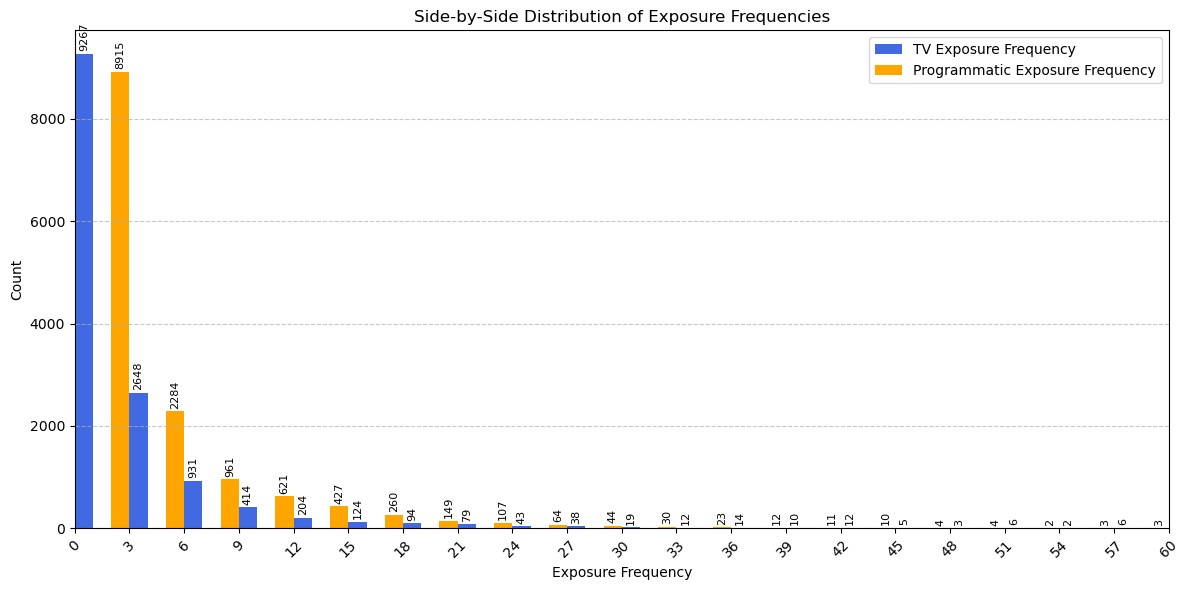

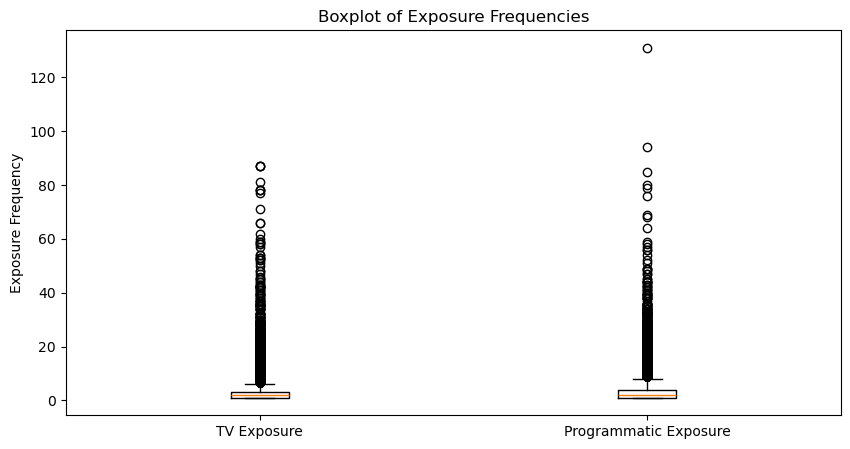

In [107]:
# Prepare bins
bins = np.arange(0, 61, 3)  # Define bins (0 to 60 with a step of 3)
tv_hist, _ = np.histogram(df['freq_tv'], bins=bins)
prog_hist, _ = np.histogram(df['freq_prog'], bins=bins)

# Define bar positions
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2  # Center of bins
width = (bins[1] - bins[0]) / 3  # Bar width for side-by-side placement

# Create the bar plot
plt.figure(figsize=(12, 6))
bars1 = plt.bar(bin_centers - width, tv_hist, width=width, label='TV Exposure Frequency', color='royalblue', align='center')
bars2 = plt.bar(bin_centers + width, prog_hist, width=width, label='Programmatic Exposure Frequency', color='orange', align='center')

# Add value annotations to the bars for clarity (for non-zero values)
for bar in bars1 + bars2:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height + 50, f'{int(height)}', 
                 ha='center', va='bottom', fontsize=8, rotation=90)

# Add gridlines and labels
plt.xlabel('Exposure Frequency')
plt.ylabel('Count')
plt.title('Side-by-Side Distribution of Exposure Frequencies')
plt.xticks(bins, rotation=45)  # Ensure all bins are labeled clearly
plt.xlim(0, 60)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal gridlines
plt.legend()
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Plot boxplots for freq_tv and freq_prog
plt.figure(figsize=(10, 5))
plt.boxplot([df['freq_tv'], df['freq_prog']], labels=['TV Exposure', 'Programmatic Exposure'])
plt.ylabel('Exposure Frequency')
plt.title('Boxplot of Exposure Frequencies')
plt.show()

In [108]:
# Sales Analysis by Channel
# Group by exposure for TV and Programmatic
tv_stats = df.groupby('exposed_tv').agg(
    total_sales=('sales', 'sum'),
    avg_sales_per_customer=('sales', 'mean'),
    total_quantity_sold=('quantity', 'sum')
).reset_index()

prog_stats = df.groupby('exposed_prog').agg(
    total_sales=('sales', 'sum'),
    avg_sales_per_customer=('sales', 'mean'),
    total_quantity_sold=('quantity', 'sum')
).reset_index()

# Display the summarized statistics
print("TV Exposure Stats:")
print(tv_stats)
print("\nProgrammatic Exposure Stats:")
print(prog_stats)

TV Exposure Stats:
   exposed_tv  total_sales  avg_sales_per_customer  total_quantity_sold
0        True   1780358.15              127.688313              43841.0

Programmatic Exposure Stats:
   exposed_prog  total_sales  avg_sales_per_customer  total_quantity_sold
0          True   1780358.15              127.688313              43841.0



Cross-Channel Exposure Stats:
   exposed_combined  total_sales  avg_sales_per_customer  total_quantity_sold
0              True   1780358.15              127.688313              43841.0


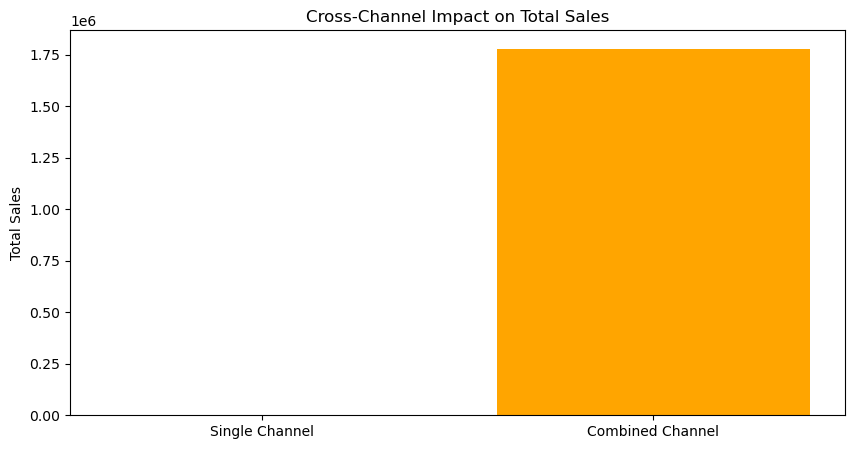

In [109]:
# Cross-Channel Impact
# Group by combined exposure
combined_stats = df.groupby('exposed_combined').agg(
    total_sales=('sales', 'sum'),
    avg_sales_per_customer=('sales', 'mean'),
    total_quantity_sold=('quantity', 'sum')
).reset_index()

# Display cross-channel impact stats
print("\nCross-Channel Exposure Stats:")
print(combined_stats)

# Ensure that exposed_combined has both True and False values
# Dynamically get sales data for plotting
sales_data = [
    combined_stats.loc[combined_stats['exposed_combined'] == False, 'total_sales'].values[0]
    if False in combined_stats['exposed_combined'].values else 0,
    combined_stats.loc[combined_stats['exposed_combined'] == True, 'total_sales'].values[0]
    if True in combined_stats['exposed_combined'].values else 0
]

# Visualization for Cross-Channel Impact
plt.figure(figsize=(10, 5))
labels = ['Single Channel', 'Combined Channel']
plt.bar(labels, sales_data, color=['skyblue', 'orange'])
plt.ylabel('Total Sales')
plt.title('Cross-Channel Impact on Total Sales')
plt.show()

### Segmentation

In [110]:
# Segment by Exposure Frequency Quartiles
# Dynamically create labels based on the number of bins
tv_bins = pd.qcut(df['freq_tv'], q=4, duplicates='drop')
tv_labels = [f"Q{i+1}" for i in range(tv_bins.cat.categories.size)]
df['tv_quartile'] = pd.qcut(df['freq_tv'], q=4, labels=tv_labels, duplicates='drop')

prog_bins = pd.qcut(df['freq_prog'], q=4, duplicates='drop')
prog_labels = [f"Q{i+1}" for i in range(prog_bins.cat.categories.size)]
df['prog_quartile'] = pd.qcut(df['freq_prog'], q=4, labels=prog_labels, duplicates='drop')

# Summarize sales and quantity by TV exposure quartile
tv_quartile_stats = df.groupby('tv_quartile').agg(
    total_sales=('sales', 'sum'),
    avg_sales=('sales', 'mean'),
    total_quantity=('quantity', 'sum'),
    count=('customer_id', 'count')
).reset_index()

# Summarize sales and quantity by Programmatic exposure quartile
prog_quartile_stats = df.groupby('prog_quartile').agg(
    total_sales=('sales', 'sum'),
    avg_sales=('sales', 'mean'),
    total_quantity=('quantity', 'sum'),
    count=('customer_id', 'count')
).reset_index()

print("TV Exposure Quartile Stats:")
print(tv_quartile_stats)

print("\nProgrammatic Exposure Quartile Stats:")
print(prog_quartile_stats)

TV Exposure Quartile Stats:
  tv_quartile  total_sales   avg_sales  total_quantity  count
0          Q1   1189908.57  128.402781         29308.0   9267
1          Q2    159423.27  131.863747          3948.0   1209
2          Q3    431026.31  124.322558         10585.0   3467

Programmatic Exposure Quartile Stats:
  prog_quartile  total_sales   avg_sales  total_quantity  count
0            Q1   1072417.14  120.293566         26963.0   8915
1            Q2    224718.67  130.120828          5391.0   1727
2            Q3    483222.34  146.386653         11487.0   3301


C:\Users\lenna\AppData\Local\Temp\ipykernel_16360\3026869609.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tv_quartile_stats = df.groupby('tv_quartile').agg(
C:\Users\lenna\AppData\Local\Temp\ipykernel_16360\3026869609.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prog_quartile_stats = df.groupby('prog_quartile').agg(


#### Analysis of missing Q4

Unique values in 'freq_tv':
freq_tv
1     6893
2     2374
3     1209
4      869
5      570
      ... 
71       1
77       1
78       3
81       1
87       3
Name: count, Length: 64, dtype: int64

Unique values in 'freq_prog':
freq_prog
1      6749
2      2166
3      1043
4       684
5       557
       ... 
79        1
80        1
85        1
94        1
131       1
Name: count, Length: 64, dtype: int64

Descriptive Statistics for 'freq_tv':
count    13943.000000
mean         3.357742
std          5.345619
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         87.000000
Name: freq_tv, dtype: float64

Descriptive Statistics for 'freq_prog':
count    13943.000000
mean         3.925841
std          5.835571
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        131.000000
Name: freq_prog, dtype: float64

Max value for 'freq_tv': 87
Max value for 'freq_prog': 131
Number of rows with max 'freq_tv' (87): 

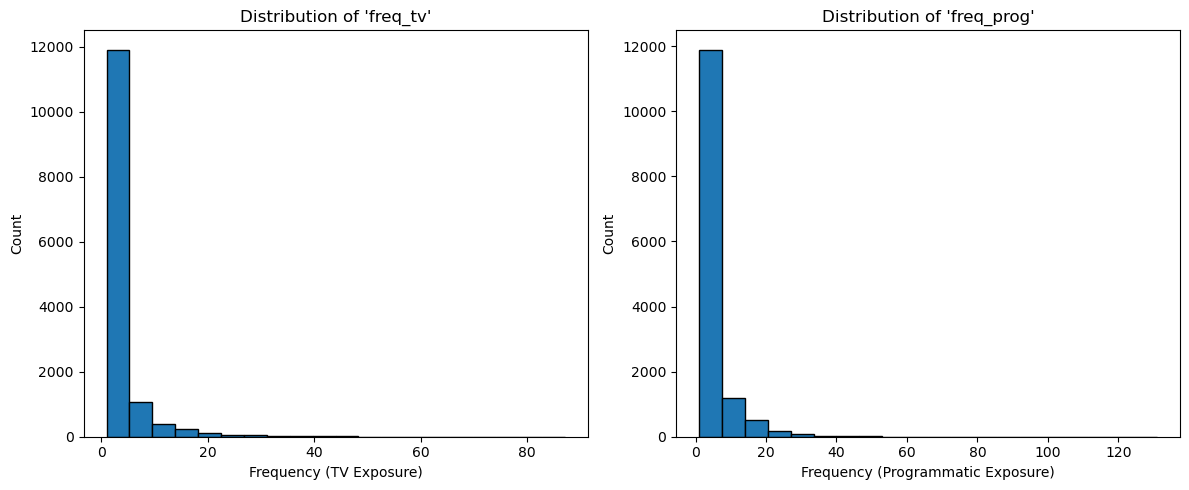

In [111]:
# Check unique values and value counts for freq_tv and freq_prog
print("Unique values in 'freq_tv':")
print(df['freq_tv'].value_counts().sort_index())

print("\nUnique values in 'freq_prog':")
print(df['freq_prog'].value_counts().sort_index())

# Check descriptive statistics for freq_tv and freq_prog
print("\nDescriptive Statistics for 'freq_tv':")
print(df['freq_tv'].describe())

print("\nDescriptive Statistics for 'freq_prog':")
print(df['freq_prog'].describe())

# Identify any max or upper outliers
max_freq_tv = df['freq_tv'].max()
max_freq_prog = df['freq_prog'].max()

print(f"\nMax value for 'freq_tv': {max_freq_tv}")
print(f"Max value for 'freq_prog': {max_freq_prog}")

# Check the distribution of max values to identify concentration
tv_max_values = df[df['freq_tv'] == max_freq_tv].shape[0]
prog_max_values = df[df['freq_prog'] == max_freq_prog].shape[0]

print(f"Number of rows with max 'freq_tv' ({max_freq_tv}): {tv_max_values}")
print(f"Number of rows with max 'freq_prog' ({max_freq_prog}): {prog_max_values}")

# Visualize the distribution to spot concentration issues
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Histogram for freq_tv
plt.subplot(1, 2, 1)
plt.hist(df['freq_tv'], bins=20, edgecolor='black')
plt.title("Distribution of 'freq_tv'")
plt.xlabel("Frequency (TV Exposure)")
plt.ylabel("Count")

# Histogram for freq_prog
plt.subplot(1, 2, 2)
plt.hist(df['freq_prog'], bins=20, edgecolor='black')
plt.title("Distribution of 'freq_prog'")
plt.xlabel("Frequency (Programmatic Exposure)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

##### Analyze whether increasing ad exposure leads to diminishing returns.

In [115]:
# Remove rows where 'sales' is zero
df = df[df['sales'] > 0]

# Verify if zero-value rows are removed
print("Remaining rows with zero sales:", (df['sales'] == 0).sum())
print("Shape of the dataframe after removal:", df.shape)

Remaining rows with zero sales: 0
Shape of the dataframe after removal: (13913, 18)


In [136]:
# Group data and compute avg_sales explicitly
tv_exposure_stats = df.groupby('freq_tv').agg(
    total_sales=('sales', 'sum'),
    customer_count=('customer_id', 'count')
).reset_index()

tv_exposure_stats['avg_sales'] = tv_exposure_stats['total_sales'] / tv_exposure_stats['customer_count']

prog_exposure_stats = df.groupby('freq_prog').agg(
    total_sales=('sales', 'sum'),
    customer_count=('customer_id', 'count')
).reset_index()

prog_exposure_stats['avg_sales'] = prog_exposure_stats['total_sales'] / prog_exposure_stats['customer_count']

# Recheck the results
print("\nTV Exposure Stats (Recomputed):")
print(tv_exposure_stats)

print("\nProgrammatic Exposure Stats (Recomputed):")
print(prog_exposure_stats)


TV Exposure Stats (Recomputed):
    freq_tv  total_sales  customer_count   avg_sales
0         1    893965.53            6880  129.936850
1         2    295943.04            2368  124.975946
2         3    159423.27            1205  132.301469
3         4    102684.94             866  118.573834
4         5     73797.64             568  129.925423
..      ...          ...             ...         ...
59       71        19.99               1   19.990000
60       77       100.96               1  100.960000
61       78       454.59               3  151.530000
62       81        44.98               1   44.980000
63       87       411.26               3  137.086667

[64 rows x 4 columns]

Programmatic Exposure Stats (Recomputed):
    freq_prog  total_sales  customer_count   avg_sales
0           1    809303.19            6740  120.074657
1           2    263113.95            2160  121.812014
2           3    134693.71            1042  129.264597
3           4     90024.96             682  1

c:\Users\lenna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lenna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lenna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lenna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

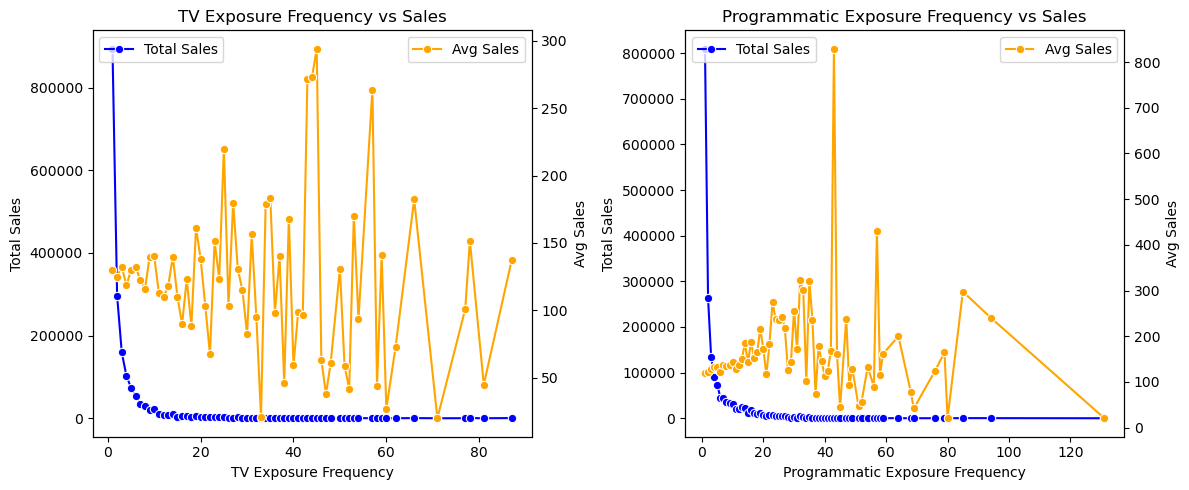

In [137]:
# Visualize Total Sales vs Exposure Frequency

plt.figure(figsize=(12, 5))

# TV Exposure
plt.subplot(1, 2, 1)
ax1 = sns.lineplot(data=tv_exposure_stats, x='freq_tv', y='total_sales', marker='o', label='Total Sales', color='blue')
ax2 = ax1.twinx()  # Add secondary y-axis
sns.lineplot(data=tv_exposure_stats, x='freq_tv', y='avg_sales', marker='o', label='Avg Sales', color='orange', ax=ax2)
ax1.set_title('TV Exposure Frequency vs Sales')
ax1.set_xlabel('TV Exposure Frequency')
ax1.set_ylabel('Total Sales')
ax2.set_ylabel('Avg Sales')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Programmatic Exposure
plt.subplot(1, 2, 2)
ax1 = sns.lineplot(data=prog_exposure_stats, x='freq_prog', y='total_sales', marker='o', label='Total Sales', color='blue')
ax2 = ax1.twinx()  # Add secondary y-axis
sns.lineplot(data=prog_exposure_stats, x='freq_prog', y='avg_sales', marker='o', label='Avg Sales', color='orange', ax=ax2)
ax1.set_title('Programmatic Exposure Frequency vs Sales')
ax1.set_xlabel('Programmatic Exposure Frequency')
ax1.set_ylabel('Total Sales')
ax2.set_ylabel('Avg Sales')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [139]:
# Analyze for diminishing returns
# Check correlation between exposure frequency and average sales
tv_corr = tv_exposure_stats[['freq_tv', 'avg_sales']].corr().iloc[0, 1]
prog_corr = prog_exposure_stats[['freq_prog', 'avg_sales']].corr().iloc[0, 1]

print(f"Correlation between TV Exposure Frequency and Average Sales: {tv_corr:.2f}")
print(f"Correlation between Programmatic Exposure Frequency and Average Sales: {prog_corr:.2f}")

Correlation between TV Exposure Frequency and Average Sales: -0.10
Correlation between Programmatic Exposure Frequency and Average Sales: -0.05
